# Real Estate Transactions in Fortaleza – ITBI Dataset
**Author:** Leonardo Sampaio Rocha  
*PhD in Computer Science | Data Scientist & ML Engineer*  
**Date:** September 2025


---

The Municipality of Fortaleza (Brazil) provides open data on real estate transactions subject to the **Imposto sobre Transmissão de Bens Imóveis (ITBI)** — a municipal tax applied when property ownership is transferred.  

The dataset includes key information such as:  
- Assessed value (*valor venal*) and taxable base value (*valor de base de cálculo*).  
- Neighborhood and location of the property.  
- Built area, usage type, and construction quality.  
- Transaction dates and cadastral records.  


### Objectives of this study
The goal of this notebook is to perform an end-to-end analysis of the dataset, covering:  

1. **Data loading and cleaning** – understanding the dataset structure, data types, missing values, and necessary transformations.  
2. **Exploratory analysis** – investigating geographical distribution, property values, and other descriptive insights.  
3. **Temporal trends** – analyzing the evolution of property values across time.  
4. **Predictive modeling** – building regression models to estimate transaction values and classification models to categorize properties into value ranges.  
5. **Results and interpretation** – summarizing insights that could inform real estate market trends and decision making.  


Part 1 – Loading and Transforming the Data

In this section, we begin by loading the dataset into a Pandas DataFrame and performing an initial exploration to understand its structure and quality. The main steps include:

- Loading the data using pandas.read_csv() and displaying the first few rows for inspection.

- Determining the dataset size: number of entries (rows) and variables (columns).

- Checking data types (dtypes) of each column, and identifying fields that should be converted to datetime or numeric formats.

- Assessing missing values: which columns contain nulls and in what proportion.

- Identifying non-analytical fields, such as IDs or metadata, that may not be relevant for the analysis.

In [1]:
import pandas as pd

df = pd.read_csv('../data/raw/dados_abertos_itbi_transacoes_imobiliarias.csv', 
                 encoding='latin1',
                 sep=";",
                 decimal=',',
                 thousands='.')

In [2]:
df.head()

,VERSAO,ID_AVALIACAO,INSCRICAO_IMOVEL,NUM_DTI,EXERCICIO,DATA_CADASTRAMENTO_GI_IMOVEL,TIPO_TRANSMITENTE,TIPO_ADQUIRENTE,NUMERO_CEP,BAIRRO,...,ANO_MES_DEBITO,NOME_ZONEAMENTO,ZONA_CARTORIO,DATA_DA_TRANSACAO_ITBI,ID_IMOVEL,CARTOGRAFIA,VL_BASE_CALCULO,VL_VENAL,VL_LANCAMENTO_IPTU,IND_COMPRA_VIA_PROGRAMA_HABITACIONAL
0,1,1146742.0,847606,1852/2025,2025,29/01/2025 09:38:03,Fisica,Juridica,60135270.0,ALDEOTA,...,2025/JANEIRO,ZONA DE OCUPAÇÃO CONSOLIDADA,4ª Zona,NaN,2077457,18-95-100,310000.0,96347.83,920.13,Nenhum
1,1,1146744.0,658735,1855/2025,2025,29/01/2025 09:52:42,Fisica,Fisica,60714170.0,ITAPERI,...,2025/JANEIRO,ZONA DE REQUALIFICAÇÃO URBANA 1,6ª Zona,NaN,1735542,41-51-313,191900.0,44641.48,268.96,Nenhum
2,1,1146855.0,604294,1967/2025,2025,30/01/2025 11:32:39,Fisica,Juridica,60125035.0,ALDEOTA,...,2025/JANEIRO,ZONA DE OCUPAÇÃO CONSOLIDADA,4ª Zona,NaN,1978011,9-22-395,119140.0,20157.29,192.50,Nenhum
3,1,1150465.0,75527,5687/2025,2025,24/03/2025 09:11:39,Juridica,Juridica,60030100.0,CENTRO,...,2025/MARCO,ZONA DE OCUPAÇÃO PREFERENCIAL 1,3ª Zona,NaN,1336635,2-20-274,54850.0,22033.49,122.08,Nenhum
4,1,1144867.0,698740,47/2025,2025,02/01/2025 14:26:29,Fisica,Fisica,60191335.0,MANUEL DIAS BRANCO,...,2025/JANEIRO,ZONA DE INTERESSE AMBIENTAL DO COCO,5ª Zona,NaN,1989622,55-73-566,355000.0,117242.74,687.37,Sistema Financeiro de Habitação


In [3]:
df.shape

(30101, 33)

In [4]:
df.dtypes

VERSAO                                    int64
ID_AVALIACAO                            float64
INSCRICAO_IMOVEL                          int64
NUM_DTI                                  object
EXERCICIO                                 int64
DATA_CADASTRAMENTO_GI_IMOVEL             object
TIPO_TRANSMITENTE                        object
TIPO_ADQUIRENTE                          object
NUMERO_CEP                              float64
BAIRRO                                   object
LOGRADOURO                               object
NUMERO                                  float64
XSIRGAS2000                             float64
YSIRGAS2000                             float64
QTD_FRENTES                               int64
FRACAO_IDEAL                            float64
AREA_TERRENO                            float64
AREA_EDIFICADA                          float64
DATA_CONSTRUCAO                          object
NUMERO_PAVIMENTOS                       float64
TIPO_USO_IMOVEL                         

In [ ]:
# Convert columns into datetime objects

cols_data = [
    'DATA_CADASTRAMENTO_GI_IMOVEL',
    'DATA_CONSTRUCAO',
    'DATA_DA_TRANSACAO_ITBI'
]

for col in cols_data:
    df[col] = pd.to_datetime(df[col], errors='coerce', dayfirst=True, infer_datetime_format=True)


In [ ]:
# The 'ANO_MES_DEBITO' column stores year/month information in a non-standard format.
# Example of values: "2020/JANEIRO", "2019/DEZEMBRO", etc.
# Since month names are written in Portuguese, we need a custom mapping.

meses = {'JANEIRO':1, 'FEVEREIRO':2, 'MARCO':3, 'ABRIL':4, 'MAIO':5, 'JUNHO':6,
         'JULHO':7, 'AGOSTO':8, 'SETEMBRO':9, 'OUTUBRO':10, 'NOVEMBRO':11, 'DEZEMBRO':12}

df['ANO_MES_DEBITO'] = df['ANO_MES_DEBITO'].apply(
    lambda x: pd.Timestamp(int(x.split('/')[0]), meses.get(x.split('/')[1].upper()), 1)
    if isinstance(x, str) and '/' in x and x.split('/')[1].upper() in meses else pd.NaT
)

In [14]:
# Build a summary DataFrame ("relatorio") with information about missing values

missing = pd.DataFrame({
    'coluna': df.columns,
    'ausentes': df.isna().sum().values,
    'percentual (%)': (df.isna().mean() * 100).round(2).values
})

missing.sort_values('percentual (%)', ascending=False).reset_index(drop=True).head(33)



,coluna,ausentes,percentual (%)
0,TIPO_TERRENO,30101,100.00
1,DATA_DA_TRANSACAO_ITBI,26630,88.47
2,NOME_ZONEAMENTO,5308,17.63
3,DATA_CONSTRUCAO,4987,16.57
4,NUMERO_PAVIMENTOS,4878,16.21
5,ID_AVALIACAO,2169,7.21
6,VL_BASE_CALCULO,2169,7.21
7,VL_LANCAMENTO_IPTU,2159,7.17
8,NUMERO,1670,5.55
9,AREA_EDIFICADA,746,2.48


In [ ]:
# Dropping the ones with more than 80% of missing values

df = df.drop(columns=['TIPO_TERRENO', 'DATA_DA_TRANSACAO_ITBI'])

---

## Part 2 – Exploratory Data Analysis (EDA)

In this section, we explore different dimensions of the dataset to better understand the real estate market in Fortaleza.  
The analysis is divided into four main perspectives:

- **Geographic distribution** – how property transactions are spread across neighborhoods.  
- **Property values** – descriptive statistics, distributions, and comparisons of assessed and taxable values.  
- **Property typology** – characteristics such as usage type, construction pattern, and number of floors.  
- **Temporal trends** – how transactions and values evolve over time.  




In [26]:
# Count the number of transactions per neighborhood (bairro)
bairros_count = df['BAIRRO'].value_counts()

# Display the top 20 neighborhoods
bairros_count.head(20)

MEIRELES                         2183
ALDEOTA                          2062
MONDUBIM                         1235
COCÓ                             1150
CENTRO                           1142
PASSARÉ                           935
PAPICU                            832
PRESIDENTE KENNEDY                771
PREFEITO JOSÉ WALTER              763
ENGENHEIRO LUCIANO CAVALCANTE     733
MESSEJANA                         589
JANGURUSSU                        584
PARQUE IRACEMA                    561
PAUPINA                           539
DIONÍSIO TORRES                   517
FÁTIMA                            512
CAMBEBA                           497
CARLITO PAMPLONA                  481
MUCURIPE                          465
EDSON QUEIROZ                     431
Name: BAIRRO, dtype: int64

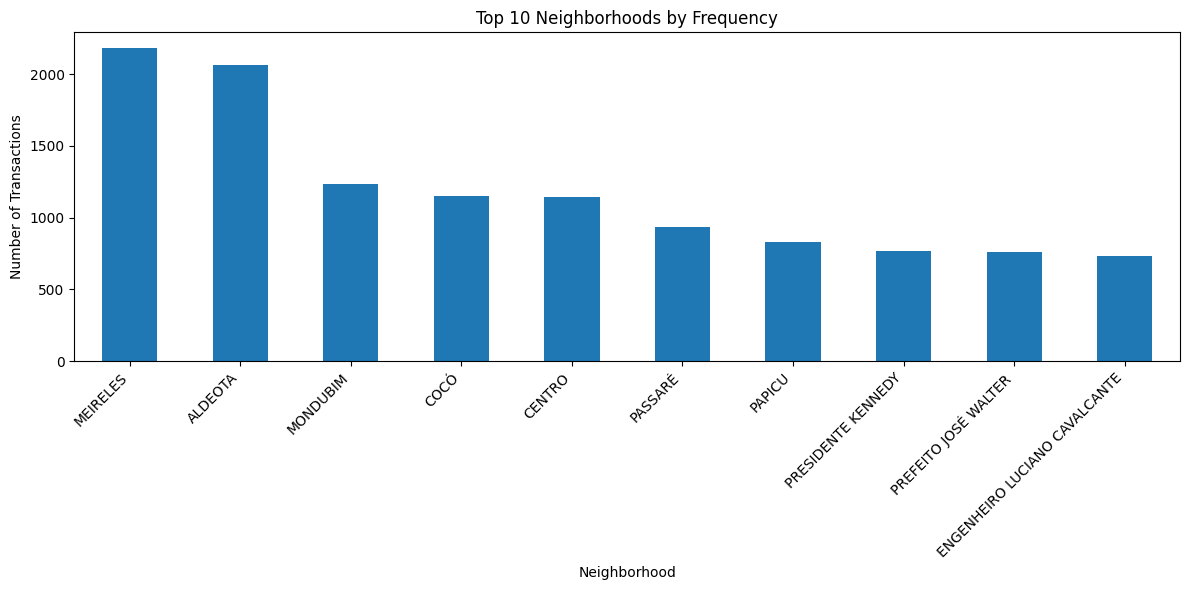

In [17]:
# Count the number of transactions per neighborhood (bairro)
# and select the top 10 neighborhoods
counts = df['BAIRRO'].value_counts().head(10)

# Create the bar chart
plt.figure(figsize=(12, 6))                        # set figure size (width, height)
counts.plot(kind='bar')                            # plot bar chart from Pandas Series
plt.title('Top 10 Neighborhoods by Frequency')     # chart title
plt.xlabel('Neighborhood')                         # x-axis label
plt.ylabel('Number of Transactions')               # y-axis label
plt.xticks(rotation=45, ha='right')                # rotate x labels for readability
plt.tight_layout()                                 # adjust layout to avoid cutoff
plt.show()                                         # display the plot


### Property Values
In this section, we examine the **monetary aspects of the real estate transactions**.  
The main questions guiding the analysis are:

**Average property values by neighborhood** – What are the mean values of `VL_BASE_CALCULO` (taxable base) and `VL_VENAL` (assessed value) across neighborhoods?  
**Distribution of transaction values** – How are property values distributed overall? Do we observe the presence of outliers?  
**Comparison between assessed value and taxable base** – When visualized side by side,  do significant discrepancies appear between `VL_VENAL` and `VL_BASE_CALCULO`?  

In [23]:
# Group the dataset by neighborhood ("BAIRRO") and calculate
# the mean values of 'VL_BASE_CALCULO' (taxable base) and 'VL_VENAL' (assessed value)
df_valor = df.groupby('BAIRRO')[['VL_BASE_CALCULO', 'VL_VENAL']].mean()

# Rename the columns to make it clear these are average values
df_valor.columns = ['avg_base_value', 'avg_assessed_value']

# Format floating point numbers with 2 decimal places and thousand separators
pd.options.display.float_format = '{:,.2f}'.format

# Sort neighborhoods by the average taxable base value (ascending)
# and display the first 20 entries
df_valor.sort_values('avg_base_value', ascending=False).head(10)


,avg_base_value,avg_assessed_value
BAIRRO,,
DE LOURDES,"1,900,004.55","744,190.36"
MEIRELES,"1,363,882.28","446,400.96"
MUCURIPE,"1,255,898.26","550,560.10"
FARIAS BRITO,"1,189,937.62","865,509.02"
GUARARAPES,"1,096,839.28","416,275.03"
MANUEL DIAS BRANCO,"1,045,255.34","285,045.56"
SABIAGUABA,"1,004,251.89","207,577.79"
CAIS DO PORTO,"991,174.54","737,792.73"
COAÇU,"920,620.88","112,784.87"


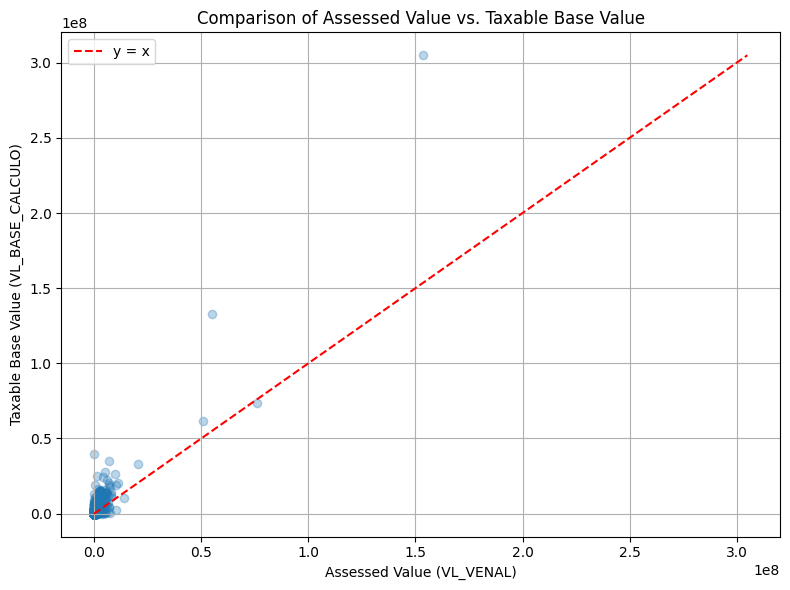

In [ ]:
import matplotlib.pyplot as plt

# Create scatter plot comparing assessed value (VL_VENAL) vs taxable base value (VL_BASE_CALCULO)
plt.figure(figsize=(8, 6))

# Plot each property as a point (alpha=0.3 makes points semi-transparent to reduce overplotting)
plt.scatter(df['VL_VENAL'], df['VL_BASE_CALCULO'], alpha=0.3)

limit = max(df['VL_VENAL'].max(), df['VL_BASE_CALCULO'].max())
plt.plot([0, limit], [0, limit], color='red', linestyle='--', label='y = x')


plt.xlabel('Assessed Value (VL_VENAL)')
plt.ylabel('Taxable Base Value (VL_BASE_CALCULO)')
plt.title('Comparison of Assessed Value vs. Taxable Base Value')

plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Conclusions from Value Comparison

- The scatter plot shows that most transactions are concentrated in the lower value range.  
- A few extreme transactions (outliers) are visible, which distort the scale.  
- The taxable base value (`VL_BASE_CALCULO`) and assessed value (`VL_VENAL`) generally follow the same trend, 
  but discrepancies are observed, especially for very high-value properties.  
- Eliminating outliers may help with a better understanding of the data.  

In [28]:


def count_outliers_by_neighborhood(df, value_column):
    """
    Count outliers in a given value column for each neighborhood (bairro).
    Outliers are defined using the IQR rule:
        Values below Q1 - 1.5*IQR or above Q3 + 1.5*IQR.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        The dataset containing neighborhoods and property values.
    value_column : str
        The name of the numeric column to evaluate (e.g., 'VL_BASE_CALCULO').

    Returns:
    --------
    pandas.DataFrame
        A summary table with the number and percentage of outliers per neighborhood,
        sorted by highest percentage of outliers.
    """
    outliers_summary = []

    # Loop through each neighborhood group
    for neighborhood, group in df.groupby('BAIRRO'):
        # Compute quartiles and IQR
        q1 = group[value_column].quantile(0.25)
        q3 = group[value_column].quantile(0.75)
        iqr = q3 - q1

        # Define outlier limits (IQR rule)
        lower_limit = q1 - 1.5 * iqr
        upper_limit = q3 + 1.5 * iqr

        # Count outliers within the group
        n_outliers = group[
            (group[value_column] < lower_limit) | (group[value_column] > upper_limit)
        ].shape[0]
        n_total = group.shape[0]

        # Append neighborhood summary
        outliers_summary.append({
            'neighborhood': neighborhood,
            'outliers': n_outliers,
            'total': n_total,
            'percent_outliers': round(100 * n_outliers / n_total, 2)
        })

    # Return as DataFrame, sorted by highest percentage of outliers
    return pd.DataFrame(outliers_summary).sort_values('percent_outliers', ascending=False)


# Example usage for taxable base value
df_outliers_base = count_outliers_by_neighborhood(df, 'VL_BASE_CALCULO')

# Example usage for assessed value
df_outliers_venal = count_outliers_by_neighborhood(df, 'VL_VENAL')


print("Outliers in VL_BASE_CALCULO:\n", df_outliers_base.head(), "\n")
print("Outliers in VL_VENAL:\n", df_outliers_venal.head())


Outliers in VL_BASE_CALCULO:
            neighborhood  outliers  total  percent_outliers
3       ALTO DA BALANÇA        16     36             44.44
90      PARQUE SÃO JOSÉ         5     18             27.78
7               ARACAPÉ         5     22             22.73
17        CAIS DO PORTO         8     37             21.62
101  PRAIA DO FUTURO II        77    360             21.39 

Outliers in VL_VENAL:
        neighborhood  outliers  total  percent_outliers
5            ANCURI        10     27             37.04
67    MANOEL SÁTIRO        29    102             28.43
17    CAIS DO PORTO         9     37             24.32
6   ANTÔNIO BEZERRA        60    273             21.98
0        AEROLÂNDIA         7     33             21.21


In [33]:
# we now replace outliers with median values from each neighbourhood group

def replace_outliers_with_median(df, value_column, group_col='BAIRRO'):
    """
    Replace outliers in a numeric column with the group-specific median.
    Outliers are defined using the IQR rule (1.5 * IQR).
    
    Parameters:
    -----------
    df : pandas.DataFrame
        The input dataset.
    value_column : str
        The name of the numeric column to correct (e.g., 'VL_VENAL').
    group_col : str, default='BAIRRO'
        Column used to group the data (e.g., neighborhood).
    
    Returns:
    --------
    pandas.DataFrame
        A copy of the dataset where outliers have been replaced with the group median.
    """
    
    # Make a copy of the dataset to avoid modifying the original
    df_corrected = df.copy()

    # Loop through each group (e.g., each neighborhood)
    for group, group_df in df.groupby(group_col):
        
        # Skip groups with very few valid entries (less than 5 values)
        if group_df[value_column].notna().sum() < 5:
            continue
        
        # Compute Q1, Q3, and IQR for the group
        q1 = group_df[value_column].quantile(0.25)
        q3 = group_df[value_column].quantile(0.75)
        iqr = q3 - q1
        lower_limit = q1 - 1.5 * iqr
        upper_limit = q3 + 1.5 * iqr
        
        # Compute the group median
        median_value = group_df[value_column].median()
        
        # Identify outliers in the group
        mask_outlier = (group_df[value_column] < lower_limit) | (group_df[value_column] > upper_limit)
        
        # Replace outliers with the group median in the corrected DataFrame
        outlier_indices = group_df[mask_outlier].index
        df_corrected.loc[outlier_indices, value_column] = median_value

    return df_corrected


# Example usage: replace outliers in 'VL_VENAL' and 'VL_BASE_CALCULO'
df_filtered = replace_outliers_with_median(df, 'VL_VENAL')
df_filtered = replace_outliers_with_median(df_filtered, 'VL_BASE_CALCULO')


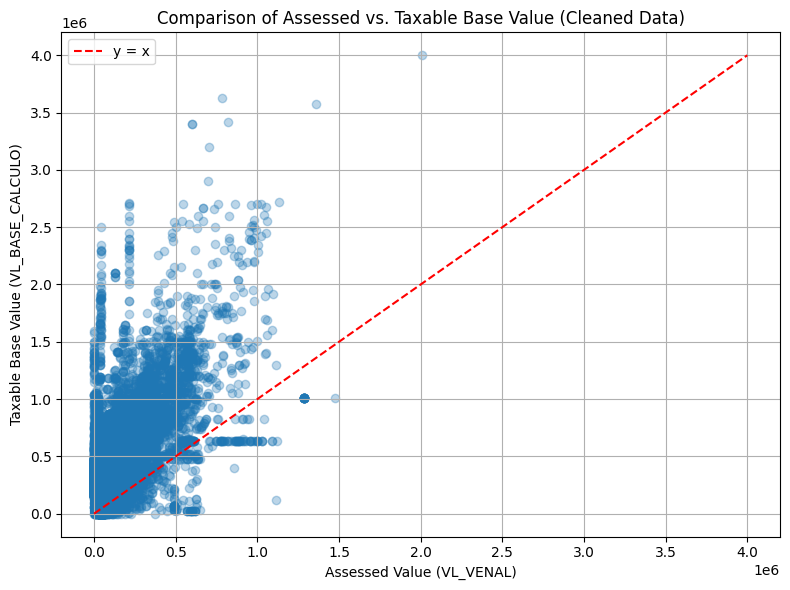

In [34]:
# Scatter plot comparing assessed value (VL_VENAL) vs taxable base value (VL_BASE_CALCULO)
# using the cleaned dataset (df_filtered, after outlier replacement)

plt.figure(figsize=(8, 6))

# Plot each property as a point (alpha=0.3 makes points semi-transparent)
plt.scatter(df_filtered['VL_VENAL'], df_filtered['VL_BASE_CALCULO'], alpha=0.3)

# Add a reference line y = x (red dashed) → points on this line mean both values are equal
limit = max(df_filtered['VL_VENAL'].max(), df_filtered['VL_BASE_CALCULO'].max())
plt.plot([0, limit], [0, limit], color='red', linestyle='--', label='y = x')

# Labels and title (in English for clarity)
plt.xlabel('Assessed Value (VL_VENAL)')
plt.ylabel('Taxable Base Value (VL_BASE_CALCULO)')
plt.title('Comparison of Assessed vs. Taxable Base Value (Cleaned Data)')

# Extras: legend, grid, and layout adjustments
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



### Property Typology
In this section, we investigate the characteristics of the properties included in the dataset.  
The analysis focuses on the following questions:

**Types of property usage** – How many distinct categories of property usage (`TIPO_USO_IMOVEL`) exist, and which one is the most common?  
**Usage vs. transaction value** – Is there a relationship between property usage type and the average transaction value?  
**Construction year vs. value** – Does the year of construction (`DATA_CONSTRUCAO`) show any correlation with property transaction values?  
**Average ideal fraction** – What is the typical fraction (e.g., ownership share or partition) of the properties being transacted?  



                 avg_base_value  avg_assessed_value  count
TIPO_USO_IMOVEL                                           
Residencial          384,082.42          124,113.22  22631
Comercial            295,366.66          108,711.28   4513
Sem                  357,507.30           62,435.84   2642
Prestação            259,325.11           97,931.89    200
Hotelaria            384,742.50          159,936.43     45
Saúde                275,610.00          111,535.27     16
Religioso            264,681.16          124,519.90     15
Instrução            303,982.70          130,715.30     14
Fechado              274,138.81          107,214.88      8
Institucional        373,852.00          143,763.88      6
Industrial           340,870.00          165,871.67      5
Do lazer             252,770.00          141,628.19      3
Transporte            37,360.00            6,173.69      2
Desportivo           349,504.28            8,452.07      1


<Figure size 1400x600 with 0 Axes>

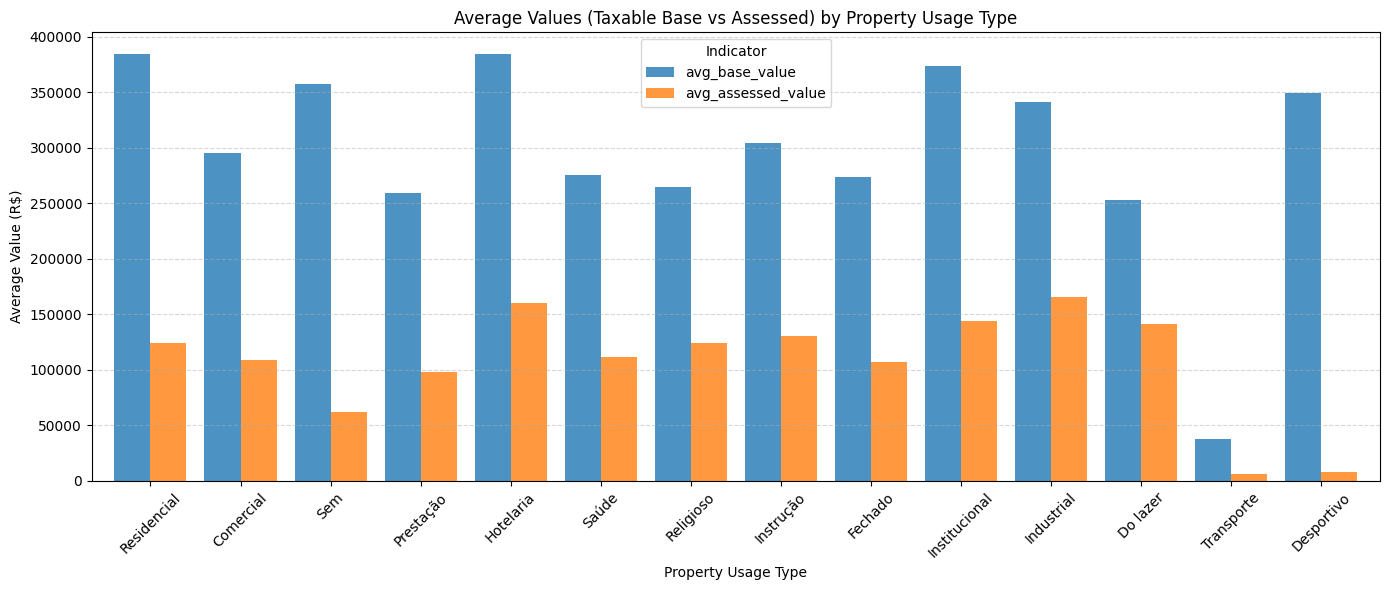

In [36]:
# Group by property usage type and calculate average values (using cleaned data)
df_valor = df_filtered.groupby('TIPO_USO_IMOVEL')[['VL_BASE_CALCULO', 'VL_VENAL']].mean()
df_valor.columns = ['avg_base_value', 'avg_assessed_value']

# Count number of properties by usage type
df_count = df_filtered['TIPO_USO_IMOVEL'].value_counts().rename('count')

# Merge averages with counts
df_valor = df_valor.join(df_count)

# Sort by count (most frequent property types at the top)
df_valor = df_valor.sort_values(by='count', ascending=False)

# Display summary table
print(df_valor)

# Visualization: bar chart

plt.figure(figsize=(14, 6))

df_valor[['avg_base_value', 'avg_assessed_value']].plot(
    kind='bar',
    figsize=(14, 6),
    width=0.8,
    alpha=0.8
)

plt.title('Average Values (Taxable Base vs Assessed) by Property Usage Type')
plt.ylabel('Average Value (R$)')
plt.xlabel('Property Usage Type')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.legend(title='Indicator')
plt.show()


---

## Comparing Property Value Distributions Across Groups

We want to investigate whether the **distribution of taxable base values (`VL_BASE_CALCULO`)**  
differs across property usage types (`TIPO_USO_IMOVEL`).  

One way to test this formally is with **ANOVA**, which compares the group means.  
However, ANOVA relies on certain assumptions about the data.  
To ensure our conclusions are reliable, we first examine the statistical properties of each group:


### 1. Normality (Shapiro-Wilk Test)
ANOVA assumes that values within each group are approximately **normally distributed**.  
If this assumption fails, the F-test may not be valid.  
We apply the **Shapiro-Wilk test** separately for each property usage type.

- **H₀ (null):** The group data follows a normal distribution.  
- **H₁ (alternative):** The group data does not follow a normal distribution.  

Since real estate prices are typically right-skewed, we anticipate deviations from normality.


### 2. Homoscedasticity (Levene’s Test)
ANOVA also assumes that groups have **equal variances**.  
If some categories have much higher variability than others, results may be biased.  
We check this using **Levene’s test**, which is more robust to non-normal data.

- **H₀ (null):** All groups have equal variances (homoscedasticity).  
- **H₁ (alternative):** At least one group has a different variance (heteroscedasticity).  

If this assumption is violated, robust alternatives like **Welch’s ANOVA** may be more appropriate.



In [40]:
import pandas as pd
from scipy.stats import shapiro, levene

# Data preparation

# Filter valid rows (drop missing values)
df_analysis = df_filtered[['TIPO_USO_IMOVEL', 'VL_BASE_CALCULO']].dropna()

# Group data by property usage type
# Keep only groups with at least 10 observations (to avoid false positives in Shapiro test)
group_dict = {
    name: group['VL_BASE_CALCULO'].values
    for name, group in df_analysis.groupby('TIPO_USO_IMOVEL')
    if len(group) >= 10
}


# 1. Normality Test (Shapiro-Wilk test, applied per group)

print("\n===== NORMALITY TEST (Shapiro-Wilk) =====")
print("Hypotheses:")
print("H0: The group data follows a normal distribution.")
print("H1: The group data does NOT follow a normal distribution.\n")

for name, values in group_dict.items():
    # Shapiro test has a performance limit (~5000 values), so slice large groups
    stat, p_value = shapiro(values[:5000])
    result = "Reject H0" if p_value < 0.05 else "Fail to reject H0"
    print(f"{name:20s} | W-statistic: {stat:.4f} | p-value: {p_value:.5f} | {result}")

# 2. Homoscedasticity Test (Levene’s Test across groups)

print("\n===== HOMOSCEDASTICITY TEST (Levene) =====")
print("Hypotheses:")
print("H0: All groups have equal variances (homoscedasticity).")
print("H1: At least one group has a different variance (heteroscedasticity).\n")

# Extract group values into a list
group_values = list(group_dict.values())

# Run Levene’s test (using the median for robustness against non-normality)
stat_levene, p_levene = levene(*group_values, center='median')

print(f"Levene statistic: {stat_levene:.2f}")
print(f"p-value: {p_levene:.5f}")

# Interpretation at 5% significance level
if p_levene < 0.05:
    print("⇒ Reject H0: there is evidence of different variances between groups (heteroscedasticity).")
else:
    print("⇒ Fail to reject H0: variances appear homogeneous across groups (homoscedasticity).")



===== NORMALITY TEST (Shapiro-Wilk) =====
Hypotheses:
H0: The group data follows a normal distribution.
H1: The group data does NOT follow a normal distribution.

Comercial            | W-statistic: 0.7717 | p-value: 0.00000 | Reject H0
Hotelaria            | W-statistic: 0.8135 | p-value: 0.00001 | Reject H0
Instrução            | W-statistic: 0.9157 | p-value: 0.32272 | Fail to reject H0
Prestação            | W-statistic: 0.8661 | p-value: 0.00000 | Reject H0
Religioso            | W-statistic: 0.8623 | p-value: 0.03275 | Reject H0
Residencial          | W-statistic: 0.7737 | p-value: 0.00000 | Reject H0
Saúde                | W-statistic: 0.7745 | p-value: 0.00245 | Reject H0
Sem                  | W-statistic: 0.8230 | p-value: 0.00000 | Reject H0

===== HOMOSCEDASTICITY TEST (Levene) =====
Hypotheses:
H0: All groups have equal variances (homoscedasticity).
H1: At least one group has a different variance (heteroscedasticity).

Levene statistic: 5.14
p-value: 0.00001
⇒ Reject H0: 

## Conclusion: Can We Use ANOVA Here?  

The diagnostic tests reveal that our dataset does not fully satisfy the assumptions required for a **classical one-way ANOVA**:  

- **Normality (Shapiro-Wilk):** Most property usage groups significantly deviate from normality. However, since large sample sizes are available for the main categories (e.g., *Residencial*, *Comercial*), this violation is less critical due to the Central Limit Theorem.  
- **Homoscedasticity (Levene’s Test):** The assumption of equal variances across groups is strongly violated. This is more problematic, as variance inequality can inflate false-positive rates in classical ANOVA.  

Because of this, applying the **standard ANOVA is not appropriate**.  

Instead, we adopt more robust alternatives:  

- **Welch’s ANOVA**


In [43]:
import pandas as pd
from scipy.stats import f_oneway
import pingouin as pg  # library with Welch's ANOVA implementation


# Welch's ANOVA: Testing whether property usage type
# affects the taxable base value without assuming equal variances


# Filter valid data
df_analysis = df_filtered[['TIPO_USO_IMOVEL', 'VL_BASE_CALCULO']].dropna()

# Run Welch’s ANOVA using pingouin
welch_results = pg.welch_anova(
    dv='VL_BASE_CALCULO',      # dependent variable
    between='TIPO_USO_IMOVEL', # independent grouping variable
    data=df_analysis
)

print("Welch’s ANOVA Results:")
print(welch_results)

# Interpretation
alpha = 0.05
p_value = welch_results['p-unc'].values[0]

print("\nInterpretation:")
if p_value < alpha:
    print(f"Since p-value = {p_value:.5f} < {alpha}, we reject H0.")
    print("⇒ There is a statistically significant difference between "
          "the taxable base values of at least one property usage type.")
else:
    print(f"Since p-value = {p_value:.5f} ≥ {alpha}, we fail to reject H0.")
    print("⇒ There is not enough evidence to conclude that property usage "
          "type affects the taxable base value.")


AttributeError: module 'pandas.arrays' has no attribute 'NumpyExtensionArray'

In [39]:
import pandas as pd
from scipy.stats import shapiro, levene

# Data preparation

# Filter valid rows (drop missing values)
df_analysis = df_filtered[['TIPO_USO_IMOVEL', 'VL_BASE_CALCULO']].dropna()

# Group data by property usage type
# Keep only groups with at least 10 observations (to avoid false positives in Shapiro test)
group_dict = {
    name: group['VL_BASE_CALCULO'].values
    for name, group in df_analysis.groupby('TIPO_USO_IMOVEL')
    if len(group) >= 10
}


# 1. Normality Test (Shapiro-Wilk test, applied per group)

print("\n===== NORMALITY TEST (Shapiro-Wilk) =====")
print("Hypotheses:")
print("H0: The group data follows a normal distribution.")
print("H1: The group data does NOT follow a normal distribution.\n")

for name, values in group_dict.items():
    # Shapiro test has a performance limit (~5000 values), so slice large groups
    stat, p_value = shapiro(values[:5000])
    result = "Reject H0" if p_value < 0.05 else "Fail to reject H0"
    print(f"{name:20s} | W-statistic: {stat:.4f} | p-value: {p_value:.5f} | {result}")

# 2. Homoscedasticity Test (Levene’s Test across groups)

print("\n===== HOMOSCEDASTICITY TEST (Levene) =====")
print("Hypotheses:")
print("H0: All groups have equal variances (homoscedasticity).")
print("H1: At least one group has a different variance (heteroscedasticity).\n")

# Extract group values into a list
group_values = list(group_dict.values())

# Run Levene’s test (using the median for robustness against non-normality)
stat_levene, p_levene = levene(*group_values, center='median')

print(f"Levene statistic: {stat_levene:.2f}")
print(f"p-value: {p_levene:.5f}")

# Interpretation at 5% significance level
if p_levene < 0.05:
    print("⇒ Reject H0: there is evidence of different variances between groups (heteroscedasticity).")
else:
    print("⇒ Fail to reject H0: variances appear homogeneous across groups (homoscedasticity).")



===== NORMALITY TEST (Shapiro-Wilk) =====
Hypotheses:
H0: The group data follows a normal distribution.
H1: The group data does NOT follow a normal distribution.

Comercial            | W-statistic: 0.7717 | p-value: 0.00000 | Reject H0
Hotelaria            | W-statistic: 0.8135 | p-value: 0.00001 | Reject H0
Instrução            | W-statistic: 0.9157 | p-value: 0.32272 | Fail to reject H0
Prestação            | W-statistic: 0.8661 | p-value: 0.00000 | Reject H0
Religioso            | W-statistic: 0.8623 | p-value: 0.03275 | Reject H0
Residencial          | W-statistic: 0.7737 | p-value: 0.00000 | Reject H0
Saúde                | W-statistic: 0.7745 | p-value: 0.00245 | Reject H0
Sem                  | W-statistic: 0.8230 | p-value: 0.00000 | Reject H0

===== HOMOSCEDASTICITY TEST (Levene) =====
Hypotheses:
H0: All groups have equal variances (homoscedasticity).
H1: At least one group has a different variance (heteroscedasticity).

Levene statistic: 5.14
p-value: 0.00001
⇒ Reject H0: 

In [ ]:
import pandas as pd
from scipy.stats import kruskal

# Hipóteses do Kruskal-Wallis
print("Hipóteses do Teste de Kruskal-Wallis (não paramétrico):")
print("H0 (nula): As diferenças observadas nas medianas entre os grupos podem ser explicadas por variações aleatórias.")
print("            Ou seja, os grupos vêm de populações com distribuições essencialmente iguais.")
print("H1 (alternativa): Pelo menos um dos grupos vem de uma distribuição significativamente diferente dos demais.\n")

# Filtrar dados válidos
df_analise = df[['TIPO_USO_IMOVEL', 'VL_BASE_CALCULO']].dropna()

# Criar lista de arrays (um array por grupo)
grupos = [grupo['VL_BASE_CALCULO'].values 
          for _, grupo in df_analise.groupby('TIPO_USO_IMOVEL') 
          if len(grupo) > 1]

# Executar o teste de Kruskal-Wallis
stat, p_value = kruskal(*grupos)

# Resultados
print("Resultado do Teste de Kruskal-Wallis:")
print(f"Estatística H: {stat:.2f}")
print(f"Valor-p: {p_value:.5f}")

# Interpretação
alpha = 0.05
print("\nInterpretação:")
if p_value < alpha:
    print(f"Como p-valor = {p_value:.5f} < {alpha}, rejeitamos H0.")
    print("⇒ Há diferença estatisticamente significativa entre as distribuições dos tipos de uso de imóvel.")
else:
    print(f"Como p-valor = {p_value:.5f} ≥ {alpha}, não rejeitamos H0.")
    print("⇒ Não há evidência suficiente para afirmar que as distribuições diferem entre os grupos.")


Hipóteses do Teste de Kruskal-Wallis (não paramétrico):
H0 (nula): As diferenças observadas nas medianas entre os grupos podem ser explicadas por variações aleatórias.
            Ou seja, os grupos vêm de populações com distribuições essencialmente iguais.
H1 (alternativa): Pelo menos um dos grupos vem de uma distribuição significativamente diferente dos demais.

Resultado do Teste de Kruskal-Wallis:
Estatística H: 252.52
Valor-p: 0.00000

Interpretação:
Como p-valor = 0.00000 < 0.05, rejeitamos H0.
⇒ Há diferença estatisticamente significativa entre as distribuições dos tipos de uso de imóvel.


Parte 2– Explorando os dados. D. Temporalidade 
12. Como se distribuem as transações ao longo do tempo (mensalmente)? 
13. Há variação de valor médio dos imóveis ao longo dos meses? 
14. Existe sazonalidade? Algum mês tem mais transações? 

In [71]:
# Converter a coluna de data da transação para índice temporal
df_time = df.copy()
df_time = df_time.set_index('DATA_DA_TRANSACAO_ITBI').sort_index()

# Média mensal de valores de transação
serie_mensal = df_time['VL_BASE_CALCULO'].resample('M').mean()

plt.figure(figsize=(12,6))
serie_mensal.plot()
plt.title('Evolução Mensal do Valor Médio de Transações')
plt.ylabel('Valor médio (R$)')
plt.xlabel('Ano')
plt.grid(True)
plt.show()

TypeError: Only valid with DatetimeIndex, TimedeltaIndex or PeriodIndex, but got an instance of 'Index'

In [ ]:
#Parte 2– Explorando os dados. D. Temporalidade 
#13. Há variação de valor médio dos imóveis ao longo dos meses?

In [ ]:
#Parte 2– Explorando os dados. D. Temporalidade 
#14. Existe sazonalidade? Algum mês tem mais transações?

Parte 3 – Predição com Aprendizado de Máquina 
A. Regressão 
1. Crie uma variável-alvo VL_BASE_CALCULO (ou VL_VENAL) para prever o valor de 
transação de um imóvel. 
2. Selecione variáveis relevantes: localização (bairro ou coordenadas), uso do imóvel, área 
do terreno, área construída, padrão de construção etc. 
3. Separe treino/teste, normalize os dados e treine um modelo de regressão. 
4. Avalie o modelo com MAE (Mean Absolute Error), RMSE (Root Mean Squared Error) e 
R² Score. 
5. Quais variáveis foram mais importantes para o modelo? 

In [ ]:
""" Predição com Aprendizado de Máquina 
A. Regressão 
1. Crie uma variável-alvo VL_BASE_CALCULO (ou VL_VENAL) para prever o valor de 
transação de um imóvel. 
2. Selecione variáveis relevantes: localização (bairro ou coordenadas), uso do imóvel, área 
do terreno, área construída, padrão de construção etc. 
3. Separe treino/teste, normalize os dados e treine um modelo de regressão. 
4. Avalie o modelo com MAE (Mean Absolute Error), RMSE (Root Mean Squared Error) e 
R² Score. 
5. Quais variáveis foram mais importantes para o modelo? """

B. Classificação 
6. Use a coluna IND_COMPRA_VIA_PROGRAMA_HABITACIONAL como alvo binário 
(0/1). 
7. Treine um classificador para prever se uma transação foi via programa habitacional. 


8. Avalie com accuracy, precision, recall e confusion matrix. 
9. Existe viés geográfico ou de tipo de imóvel nos casos de programa habitacional? 

 

In [ ]:
"""
B. Classificação 
6. Use a coluna IND_COMPRA_VIA_PROGRAMA_HABITACIONAL como alvo binário 
(0/1). 
7. Treine um classificador para prever se uma transação foi via programa habitacional. 


8. Avalie com accuracy, precision, recall e confusion matrix. 
9. Existe viés geográfico ou de tipo de imóvel nos casos de programa habitacional? """